In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, make_scorer, f1_score,
    precision_score, recall_score
)
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')

# Load the feature matrix
df = pd.read_parquet(r"MODEL_READY_MATRIX.parquet")

print(f"Loaded matrix: {df.shape}")
print(f"  Label=1 (AD): {(df['LABEL']==1).sum()}")
print(f"  Label=0 (Control): {(df['LABEL']==0).sum()}")

# Separate features and target
feature_cols = [c for c in df.columns if c not in ['SUBJECT_ID', 'LABEL']]
X = df[feature_cols]
y = df['LABEL']

#hit memory limits so convert to sparse matrix and float32. Shouldn't lose much precision since these are mostly binary features.
X = X.astype(np.float32)
X_sparse = csr_matrix(X.values)


print(f"Features: {X.shape[1]}")

Loaded matrix: (46189, 11718)
  Label=1 (AD): 29
  Label=0 (Control): 46160
Features: 11716


In [13]:
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score, zero_division=0),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'roc_auc': 'roc_auc',
}

print(f"Cross-validation: {N_FOLDS}-fold stratified")
print(f"Positive class prevalence: {y.mean():.4f}")

Cross-validation: 5-fold stratified
Positive class prevalence: 0.0006


In [22]:
dt = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=10,          # Prevent overfitting on sparse features
    min_samples_leaf=20,   # Ensure leaves have enough samples
    random_state=42
)

print("Training Decision Tree with cross-validation...")
dt_cv = cross_validate(
    dt, X_sparse, y,
    cv=skf,
    scoring=scoring,
    return_estimator=True,  # Keep fitted models for feature importance
    n_jobs=-1
)

print("\nDecision Tree Results (mean +/- std across folds):")
for metric in scoring:
    scores = dt_cv[f'test_{metric}']
    print(f"  {metric}: {scores.mean():.4f} +/- {scores.std():.4f}")

# Average feature importances across folds
dt_importances = np.mean(
    [est.feature_importances_ for est in dt_cv['estimator']],
    axis=0
)

dt_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_importances
}).sort_values('importance', ascending=False)

print(f"\nNon-zero importance features: {(dt_importances > 0).sum()}")

Training Decision Tree with cross-validation...

Decision Tree Results (mean +/- std across folds):
  accuracy: 0.9981 +/- 0.0010
  f1: 0.4173 +/- 0.1596
  precision: 0.2832 +/- 0.1397
  recall: 0.9000 +/- 0.1333
  roc_auc: 0.9491 +/- 0.0667

Non-zero importance features: 27


In [16]:
lasso_scores = {m: [] for m in ['f1', 'precision', 'recall', 'roc_auc', 'accuracy']}
lasso_coefs = []
lasso_last_fold = {}  # Store last fold for classification report

print("Training Lasso (L1 Logistic Regression) fold by fold...")

for fold_num, (train_idx, test_idx) in enumerate(skf.split(X_sparse, y)):
    print(f"  Fold {fold_num + 1}/{N_FOLDS}...", end=" ")
    
    X_tr = X_sparse[train_idx]
    X_te = X_sparse[test_idx]
    y_tr = y.iloc[train_idx]
    y_te = y.iloc[test_idx]
    
    scaler = StandardScaler(with_mean=False)
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)
    
    del X_tr, X_te
    gc.collect()
    
    lasso = LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        max_iter=5000,
        C=1.0,
        random_state=42,
        n_jobs=1
    )
    lasso.fit(X_tr_scaled, y_tr)
    
    y_pred = lasso.predict(X_te_scaled)
    y_prob = lasso.predict_proba(X_te_scaled)[:, 1]
    
    lasso_scores['accuracy'].append((y_pred == y_te).mean())
    lasso_scores['f1'].append(f1_score(y_te, y_pred, zero_division=0))
    lasso_scores['precision'].append(precision_score(y_te, y_pred, zero_division=0))
    lasso_scores['recall'].append(recall_score(y_te, y_pred, zero_division=0))
    lasso_scores['roc_auc'].append(roc_auc_score(y_te, y_prob))
    lasso_coefs.append(np.abs(lasso.coef_[0]))
    
    # Save last fold data for classification report later
    lasso_last_fold = {
        'y_test': y_te,
        'y_pred': y_pred,
        'test_idx': test_idx
    }
    
    print(f"AUC: {lasso_scores['roc_auc'][-1]:.4f}")
    
    del X_tr_scaled, X_te_scaled, lasso, scaler, y_pred, y_prob
    gc.collect()

print("\nLasso Results (mean +/- std across folds):")
for metric in lasso_scores:
    s = np.array(lasso_scores[metric])
    print(f"  {metric}: {s.mean():.4f} +/- {s.std():.4f}")

lasso_coefs_avg = np.mean(lasso_coefs, axis=0)
lasso_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': lasso_coefs_avg
}).sort_values('importance', ascending=False)

print(f"\nNon-zero coefficient features: {(lasso_coefs_avg > 0).sum()}")

del lasso_coefs
gc.collect()

Training Lasso (L1 Logistic Regression) fold by fold...
  Fold 1/5... AUC: 0.4995
  Fold 2/5... AUC: 0.6907
  Fold 3/5... AUC: 0.7544
  Fold 4/5... AUC: 0.6546
  Fold 5/5... AUC: 0.6432

Lasso Results (mean +/- std across folds):
  f1: 0.0057 +/- 0.0060
  precision: 0.0029 +/- 0.0030
  recall: 0.2400 +/- 0.1679
  roc_auc: 0.6485 +/- 0.0840
  accuracy: 0.9409 +/- 0.0433

Non-zero coefficient features: 11478


0

In [17]:
'''
# Lasso needs scaled features for proper regularization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) #kept as X since it's not sparse and we need to scale it for Lasso

lasso = LogisticRegression(
    penalty='l1',
    solver='saga',
    class_weight='balanced',
    max_iter=5000,
    C=1.0,               # Regularization strength (lower = more regularization)
    random_state=42,
    n_jobs=1 #changing to 1 to help with memory issues on large datasets
)

print("Training Lasso (L1 Logistic Regression) with cross-validation...")
lasso_cv = cross_validate(
    lasso, X_scaled, y,
    cv=skf,
    scoring=scoring,
    return_estimator=True,
    n_jobs=1 # changing to 1 to help with memory issues on large datasets
)

print("\nLasso Results (mean +/- std across folds):")
for metric in scoring:
    scores = lasso_cv[f'test_{metric}']
    print(f"  {metric}: {scores.mean():.4f} +/- {scores.std():.4f}")

# Average absolute coefficients across folds
lasso_coefs = np.mean(
    [np.abs(est.coef_[0]) for est in lasso_cv['estimator']],
    axis=0
)

lasso_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': lasso_coefs
}).sort_values('importance', ascending=False)

print(f"\nNon-zero coefficient features: {(lasso_coefs > 0).sum()}")
'''

'\n# Lasso needs scaled features for proper regularization\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X) #kept as X since it\'s not sparse and we need to scale it for Lasso\n\nlasso = LogisticRegression(\n    penalty=\'l1\',\n    solver=\'saga\',\n    class_weight=\'balanced\',\n    max_iter=5000,\n    C=1.0,               # Regularization strength (lower = more regularization)\n    random_state=42,\n    n_jobs=1 #changing to 1 to help with memory issues on large datasets\n)\n\nprint("Training Lasso (L1 Logistic Regression) with cross-validation...")\nlasso_cv = cross_validate(\n    lasso, X_scaled, y,\n    cv=skf,\n    scoring=scoring,\n    return_estimator=True,\n    n_jobs=1 # changing to 1 to help with memory issues on large datasets\n)\n\nprint("\nLasso Results (mean +/- std across folds):")\nfor metric in scoring:\n    scores = lasso_cv[f\'test_{metric}\']\n    print(f"  {metric}: {scores.mean():.4f} +/- {scores.std():.4f}")\n\n# Average absolute coefficients acr

Accuracy = correct predictions/total predictions

precision = PPV

recall = sensitivity (true pos / total pos)

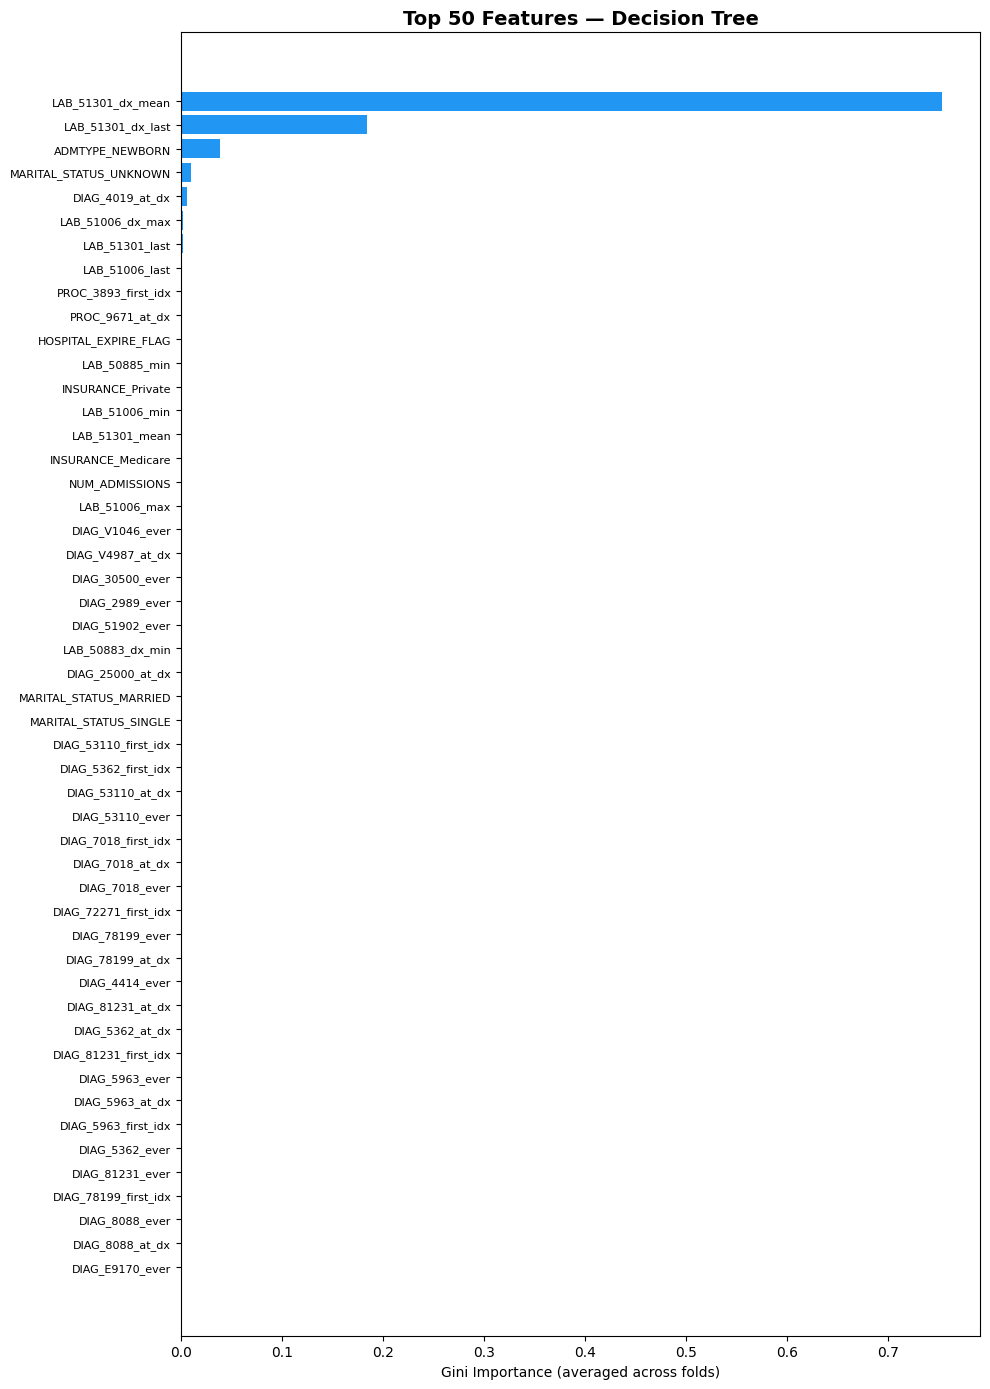

Saved: DT_Top50_Features.png


In [18]:
TOP_N = 50

dt_top = dt_importance_df.head(TOP_N).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 14))
ax.barh(dt_top['feature'], dt_top['importance'], color='#2196F3')
ax.set_xlabel('Gini Importance (averaged across folds)')
ax.set_title(f'Top {TOP_N} Features — Decision Tree', fontsize=14, fontweight='bold')
ax.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.savefig(r"DT_Top50_Features.png", dpi=150, bbox_inches='tight')
plt.show()

print("Saved: DT_Top50_Features.png")

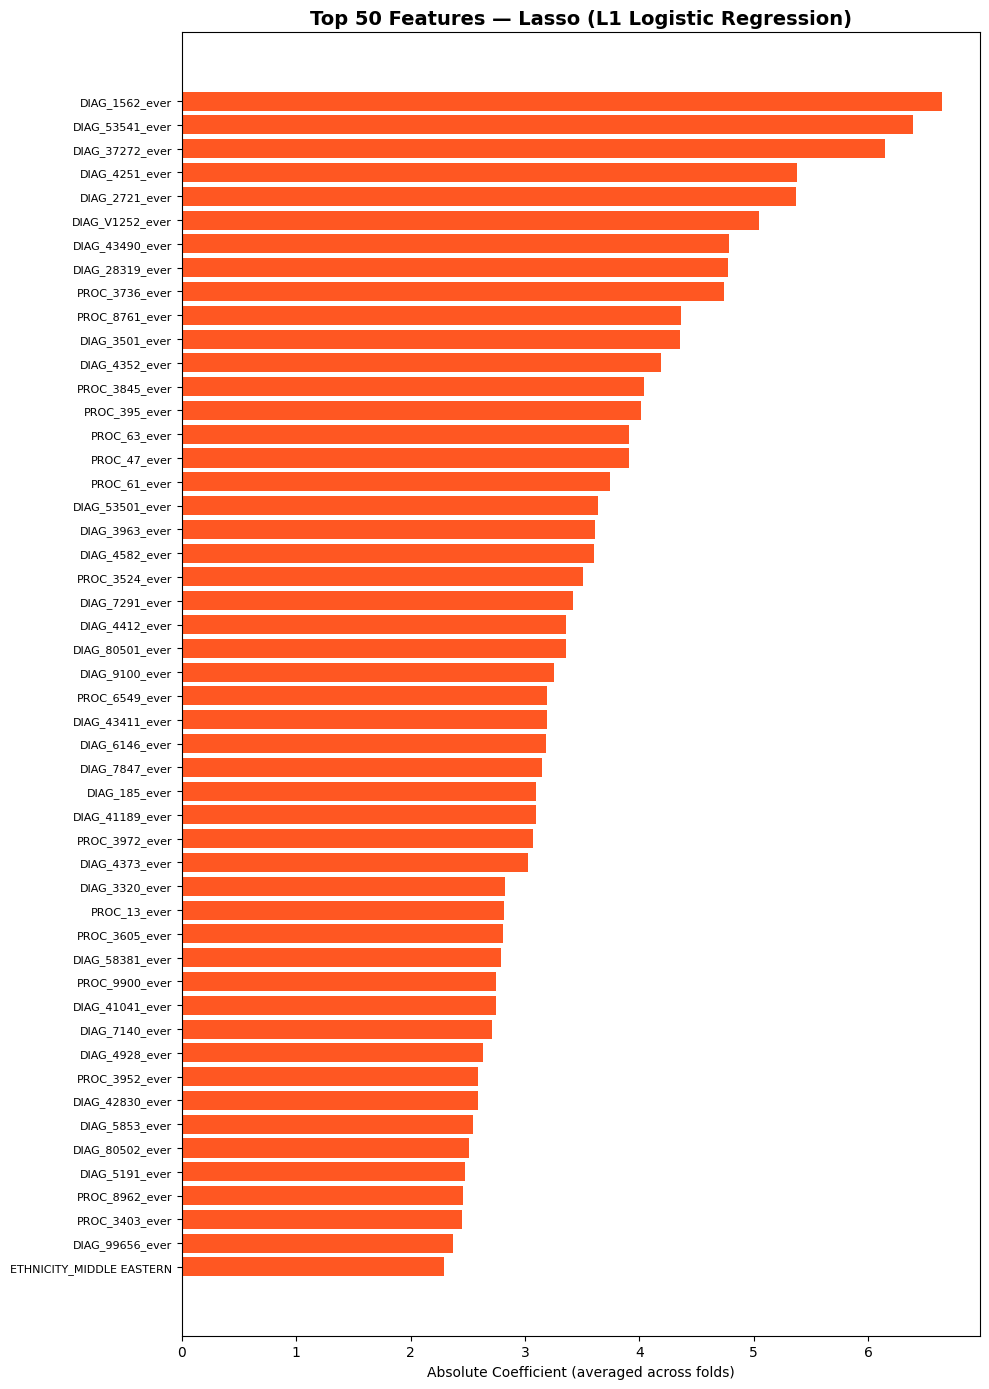

Saved: Lasso_Top50_Features.png


In [19]:
lasso_top = lasso_importance_df.head(TOP_N).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 14))
ax.barh(lasso_top['feature'], lasso_top['importance'], color='#FF5722')
ax.set_xlabel('Absolute Coefficient (averaged across folds)')
ax.set_title(f'Top {TOP_N} Features — Lasso (L1 Logistic Regression)', fontsize=14, fontweight='bold')
ax.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.savefig(r"Lasso_Top50_Features.png", dpi=150, bbox_inches='tight')
plt.show()

print("Saved: Lasso_Top50_Features.png")

In [20]:
# Show overlap between the two models' top 50
dt_top50_set = set(dt_importance_df.head(TOP_N)['feature'])
lasso_top50_set = set(lasso_importance_df.head(TOP_N)['feature'])
overlap = dt_top50_set & lasso_top50_set

print(f"\nTop {TOP_N} overlap between Decision Tree and Lasso:")
print(f"  Features in both: {len(overlap)}")
print(f"  Only in Decision Tree: {len(dt_top50_set - lasso_top50_set)}")
print(f"  Only in Lasso: {len(lasso_top50_set - dt_top50_set)}")
print(f"\nShared features:")
for f in sorted(overlap):
    print(f"  {f}")

# Export full importance rankings
dt_importance_df.to_csv(
    r"DT_Feature_Importances.csv", index=False
)
lasso_importance_df.to_csv(
    r"Lasso_Feature_Importances.csv", index=False
)

print("\nSaved full importance rankings as CSV.")


Top 50 overlap between Decision Tree and Lasso:
  Features in both: 0
  Only in Decision Tree: 50
  Only in Lasso: 50

Shared features:

Saved full importance rankings as CSV.


In [23]:
# Use the last fold's estimator for a detailed report
dt_last = dt_cv['estimator'][-1]
lasso_last = lasso_cv['estimator'][-1]

# Get the last fold's test indices
fold_indices = list(skf.split(X, y))
_, test_idx = fold_indices[-1]

X_test_fold = X_sparse[test_idx]
X_test_fold_scaled = X_scaled[test_idx]
y_test_fold = y.iloc[test_idx]

print("=" * 60)
print("Decision Tree — Classification Report (last fold)")
print("=" * 60)
dt_pred = dt_last.predict(X_test_fold)
print(classification_report(y_test_fold, dt_pred, target_names=['Control', 'AD']))

print("=" * 60)
print("Lasso — Classification Report (last fold)")
print("=" * 60)
lasso_pred = lasso_last.predict(X_test_fold_scaled)
print(classification_report(y_test_fold, lasso_pred, target_names=['Control', 'AD']))

NameError: name 'lasso_cv' is not defined

In [ ]:
'''
# Use the last fold's estimator for a detailed report
dt_last = dt_cv['estimator'][-1]
lasso_last = lasso_cv['estimator'][-1]

# Get the last fold's test indices
fold_indices = list(skf.split(X_sparse, y))
_, test_idx = fold_indices[-1]

X_test_fold = X.iloc[test_idx]
X_test_fold_scaled = X_scaled[test_idx]
y_test_fold = y.iloc[test_idx]

print("=" * 60)
print("Decision Tree — Classification Report (last fold)")
print("=" * 60)
dt_pred = dt_last.predict(X_test_fold)
print(classification_report(y_test_fold, dt_pred, target_names=['Control', 'AD']))

print("=" * 60)
print("Lasso — Classification Report (last fold)")
print("=" * 60)
lasso_pred = lasso_last.predict(X_test_fold_scaled)
print(classification_report(y_test_fold, lasso_pred, target_names=['Control', 'AD']))
'''

Decision Tree — Classification Report (last fold)
              precision    recall  f1-score   support

     Control       1.00      0.88      0.94      9232
          AD       0.04      0.71      0.08        68

    accuracy                           0.88      9300
   macro avg       0.52      0.79      0.51      9300
weighted avg       0.99      0.88      0.93      9300

Lasso — Classification Report (last fold)
              precision    recall  f1-score   support

     Control       1.00      0.91      0.95      9232
          AD       0.06      0.82      0.12        68

    accuracy                           0.91      9300
   macro avg       0.53      0.87      0.54      9300
weighted avg       0.99      0.91      0.95      9300

